In [ ]:
import torch
from PIL import Image, ImageFile
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
import random
import PIL.ImageOps
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Класс FaceDetector

In [ ]:
from Detection_model import FaceDetector

In [ ]:
yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', '/content/best200.pt')  # custom/local model

In [ ]:
!mkdir detected
!mkdir cropped

In [ ]:
test = FaceDetector(yolov5)

In [ ]:
test.general('/content/denis.jpg')

(257, 816)
Лицо сохранено


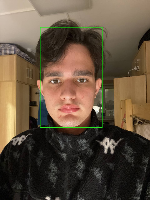

In [ ]:
full_image = cv2.imread('/content/detected/image.jpg')
full_small = cv2.resize(full_image, (150, 200))
cv2_imshow(full_small)

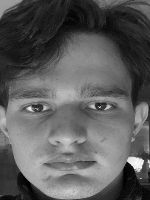

In [ ]:
cut_image = cv2.imread('/content/cropped/cut_face1.jpg')
cut_small = cv2.resize(cut_image, (150, 200))
cv2_imshow(cut_small)

# Класс SiameseNetwork

In [ ]:
from Siamese_model import ContrastiveLoss, SiameseNetworkDataset, SiameseNetwork, MyModel

In [ ]:
# !rm -r '/content/lfw-deepfunneled/'
# !rm -r '/content/data/'
# !rm -r '/content/lfw-deepfunneled/merge_folder/'
# !rm -r '/content/merge_folder/'

# !unzip 'lfw.zip'
# !unzip 'data.zip'

In [3]:
# os.chdir("/content/data/faces/training/")
# f1 = os.listdir()
# f1 = ["/content/data/faces/training/" + elem for elem in f1]
# os.chdir("/content/data/faces/testing/")
# f2 = os.listdir()
# f2 = ["/content/data/faces/testing/" + elem for elem in f2]
# os.chdir("/content/lfw-deepfunneled/")
# f3 = os.listdir()
# f3 = ["/content/lfw-deepfunneled/" + elem for elem in f3]

# os.chdir("/content/")
# os.getcwd()

In [3]:
# !mkdir dataset
# import splitfolders
# splitfolders.ratio('/content/lfw-deepfunneled/', output="dataset", seed=1337, ratio=(.8, 0.2))

Copying files: 13233 files [00:03, 3350.20 files/s]


Epoch number 0
 Current loss 2.7628633975982666

Epoch number 1
 Current loss 0.9012861251831055

Epoch number 2
 Current loss 0.4228973388671875

Epoch number 3
 Current loss 1.3125629425048828

Epoch number 4
 Current loss 1.1625151634216309

Epoch number 5
 Current loss 1.0228111743927002

Epoch number 6
 Current loss 1.2149744033813477

Epoch number 7
 Current loss 1.1813430786132812

Epoch number 8
 Current loss 1.033587098121643

Epoch number 9
 Current loss 0.40994027256965637

Epoch number 10
 Current loss 1.282562494277954

Epoch number 11
 Current loss 1.4008969068527222

Epoch number 12
 Current loss 0.736159086227417

Epoch number 13
 Current loss 0.7800129652023315

Epoch number 14
 Current loss 1.1147464513778687

Epoch number 15
 Current loss 0.7288942337036133

Epoch number 16
 Current loss 0.47167208790779114

Epoch number 17
 Current loss 1.0134943723678589

Epoch number 18
 Current loss 0.9461467266082764

Epoch number 19
 Current loss 0.8889034986495972

Epoch numbe

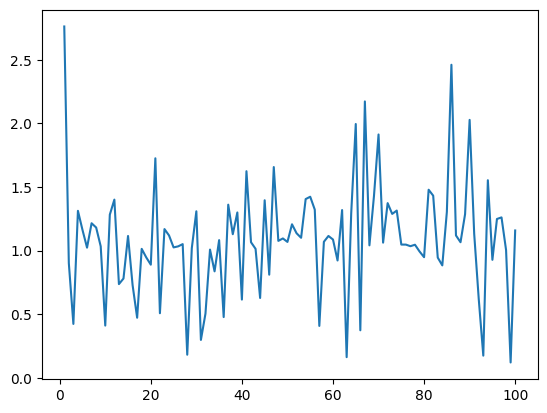

In [8]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as Data
import PIL.ImageOps
import torch.nn as nn
# from torch import optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


class Config():
    training_dir = "/content/data/faces/training/"
    testing_dir = "/content/data/faces/testing"
    train_batch_size = 16
    train_number_epochs = 100

class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

if __name__ == '__main__':
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
    train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)
    vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
    dataiter = iter(vis_dataloader)


    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1]),0)
    # imshow(torchvision.utils.make_grid(concatenated))
    # print(example_batch[2].numpy())


    net = SiameseNetwork()
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(net.parameters(),0.001,betas=(0.9, 0.99))

    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            #img0, img1 , label = img0.cpu, img1.cpu, label.cpu
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            # if i %10 == 0 :
        print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number +=1
        counter.append(iteration_number)
        loss_history.append(loss_contrastive.item())
    show_plot(counter,loss_history)
    torch.save(net.state_dict(),'net_params.pkl')

Незнакомец
Незнакомец
Есть совпадение


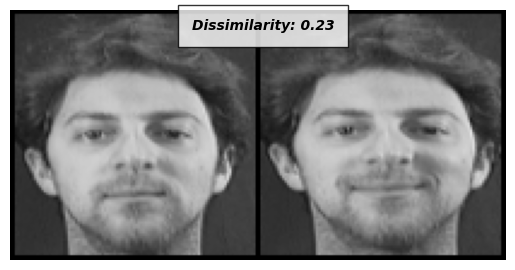

Незнакомец
Есть совпадение


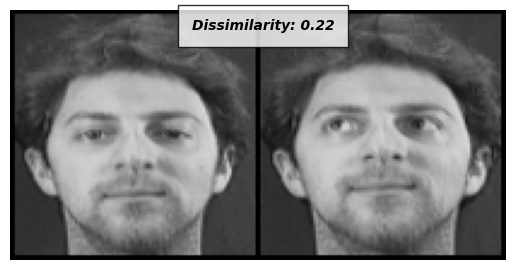

Незнакомец
Незнакомец
Есть совпадение


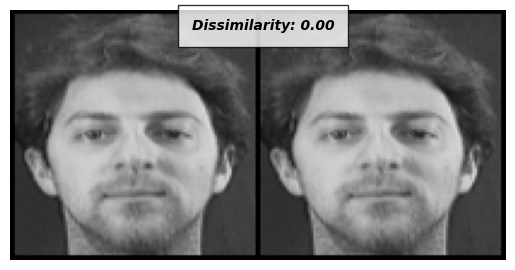

Незнакомец
Незнакомец
Незнакомец
Есть совпадение


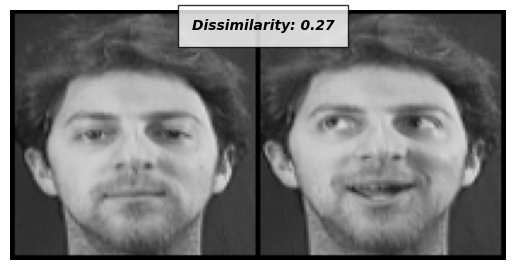

Есть совпадение


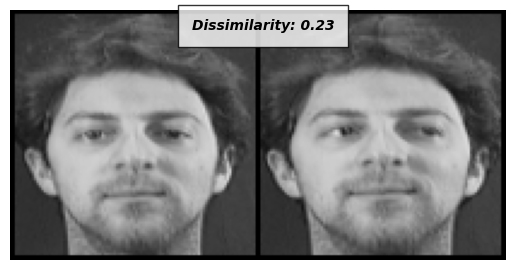

Незнакомец
Незнакомец
Незнакомец
Незнакомец
Незнакомец
Есть совпадение


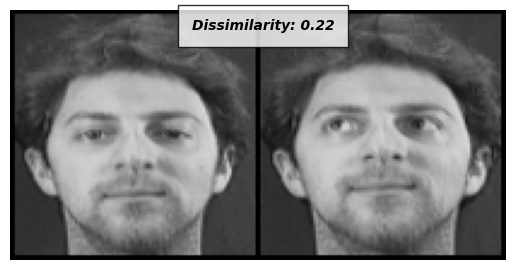

Незнакомец
Есть совпадение


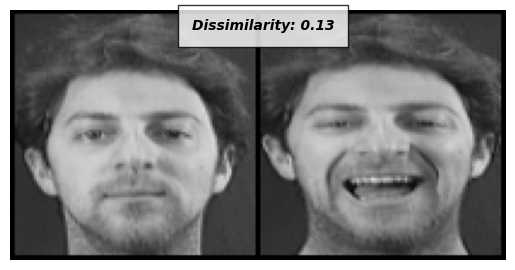

Есть совпадение


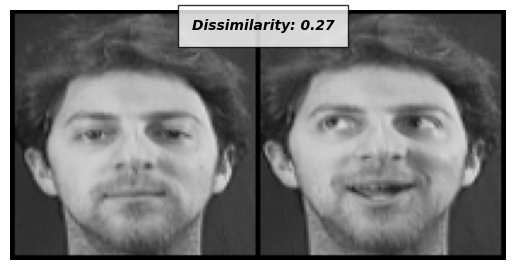

Есть совпадение


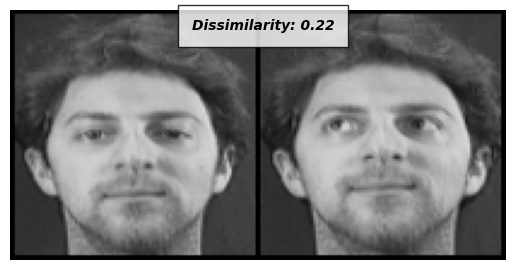

Незнакомец
Есть совпадение


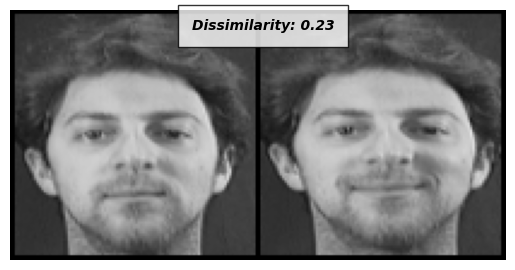

Незнакомец
Незнакомец
Незнакомец
Незнакомец


In [18]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as Data
import PIL.ImageOps
import torch.nn as nn
# from torch import optim
import torch.nn.functional as F
#plt.switch_backend('agg')

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

if __name__ == '__main__':

    net=SiameseNetwork()
    net.load_state_dict(torch.load('./net_params.pkl'))
    folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
    test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
    dataiter = iter(test_dataloader)
    x0,_,_ = next(dataiter)
    for i in range(len(dataiter)-1):
        _,x1,label2 = next(dataiter)
        concatenated = torch.cat((x0,x1),0)
        output1,output2 = net(Variable(x0),Variable(x1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        if euclidean_distance > 0.27:
          print('Незнакомец')
        else:
          print('Есть совпадение')
          imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

**Написанная архитектура сиамской нейросети принимает на вход 4d-тензоры заданного размера, а именно: (1, 1, 100, 100)**

Для этого поступающий на вход снимок преобразуем в ЧБ формат и меняем размер

In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

net = MyModel(SiameseNetworkDataset, SiameseNetwork, transform)

Подготавливаем train-выборку с помощью класса SiameseNetworkDataset и обучаем на ней сиамскую сеть

In [ ]:
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transform)
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=64)

Обучение ...


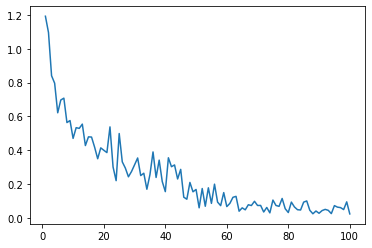

In [ ]:
net.fit(100, train_dataloader)
net.save_weights('model_100.pth')

Загружаем веса обученной нейросети

In [ ]:
net.load_weights('model_100.pth')

Тестим нейросеть на обнаруженном ранее лице

In [ ]:
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transform)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

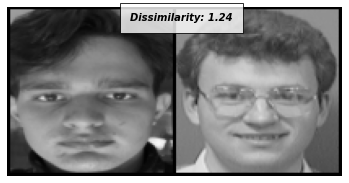

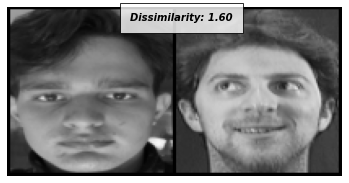

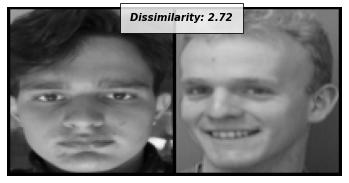

In [ ]:
net.predict('/content/cut_face1.jpg', test_dataloader)

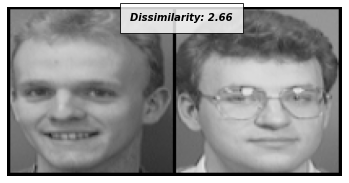

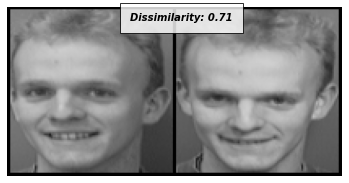

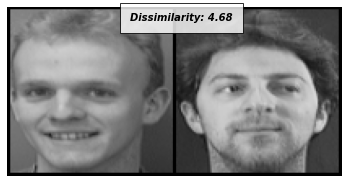

In [ ]:
net.predict('/content/data/faces/testing/s5/1.pgm', test_dataloader)